Lucas Henrique Nogueira - 202265515B

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def feasmbl1(kk, k, index):
    for i in range(len(index)):
        ii = index[i]
        for j in range(len(index)):
            jj = index[j]
            kk[ii, jj] += k[i, j]
    return kk

In [12]:
def feaplyc2(kk, ff, bcdof, bcval):
    for c, val in zip(bcdof, bcval):
        kk[c, :] = 0.0
        kk[c, c] = 1.0
        ff[c] = val
    return kk, ff

In [13]:
def feeldof1(iel, nnel, ndof):
    edof = nnel * ndof
    start = (iel - 1) * (nnel - 1) * ndof
    return np.array([start + i for i in range(edof)])

In [14]:
def feframe2(E, I, L, A, beta):

    a = E * A / L
    c = E * I / L**3

    kl = np.array([
        [ a,   0,           0,     -a,   0,           0],
        [ 0,  12*c,   6*L*c,      0, -12*c,   6*L*c],
        [ 0, 6*L*c, 4*L*L*c,      0, -6*L*c, 2*L*L*c],
        [-a,   0,           0,      a,   0,           0],
        [ 0, -12*c, -6*L*c,      0, 12*c,  -6*L*c],
        [ 0, 6*L*c, 2*L*L*c,      0, -6*L*c, 4*L*L*c]
    ])

    cb = np.cos(beta)
    sb = np.sin(beta)

    r = np.array([
        [ cb, sb, 0,  0,  0, 0],
        [-sb, cb, 0,  0,  0, 0],
        [  0,  0, 1,  0,  0, 0],
        [  0,  0, 0, cb, sb, 0],
        [  0,  0, 0,-sb, cb, 0],
        [  0,  0, 0,  0,  0, 1]
    ])

    return r.T @ kl @ r

In [ ]:
def resolver_portico(divisoes_por_segmento, plotar=True):

    # GERAÇÃO DE MALHA AUTOMÁTICA
    # P0(0,0) -> P1(0,4) -> P2(1,4) -> P3(6,4) -> P4(6,2) -> P5(6,1)
    kpts = np.array([
        [0.0, 0.0], # KP0
        [0.0, 4.0], # KP1
        [1.0, 4.0], # KP2
        [6.0, 4.0], # KP3
        [6.0, 2.0], # KP4
        [6.0, 1.0]  # KP5
    ])

    # Segmentos conectando os Keypoints
    segmentos = [(0,1), (1,2), (2,3), (3,4), (4,5)]

    x_nodes = []
    y_nodes = []
    elements = []
    current_node_id = 0

    # Gera nós e elementos interpolados
    for (start_idx, end_idx) in segmentos:
        p_start = kpts[start_idx]
        p_end   = kpts[end_idx]

        # Cria coordenadas linearmente espaçadas para este segmento
        xs = np.linspace(p_start[0], p_end[0], divisoes_por_segmento + 1)
        ys = np.linspace(p_start[1], p_end[1], divisoes_por_segmento + 1)

        # Evita duplicar o nó de conexão
        start_k = 0 if len(x_nodes) == 0 else 1

        for k in range(start_k, len(xs)):
            x_nodes.append(xs[k])
            y_nodes.append(ys[k])

            if len(x_nodes) > 1:
                # O elemento conecta o nó anterior ao atual
                elements.append((current_node_id, current_node_id + 1))
                current_node_id += 1

    x = np.array(x_nodes)
    y = np.array(y_nodes)

    # DADOS FÍSICOS
    ndof = 3
    nnel = 2
    nnode = len(x)
    sdof = nnode * ndof
    nel = len(elements)

    E = 2e11
    r = 0.03
    A = np.pi * r**2
    I = np.pi * r**4 / 4

    kk = np.zeros((sdof, sdof))
    ff = np.zeros(sdof)

    # MONTAGEM E CARGAS
    # Carga Concentrada no Ponto (0, 4)
    dist_node = np.sqrt((x - 0.0)**2 + (y - 4.0)**2)
    node_carga_conc = np.argmin(dist_node) # Índice do nó mais próximo de (0,4)

    # Aplica carga -10kN em Y
    ff[node_carga_conc * ndof + 1] += -10000.0

    # Definição das cargas distribuídas
    qy_val = 10000.0 # N/m vertical
    qx_val = 10000.0 # N/m horizontal

    for iel_idx, (n1, n2) in enumerate(elements):
        iel = iel_idx + 1
        index = feeldof1(iel, nnel, ndof).astype(int)

        x1, y1 = x[n1], y[n1]
        x2, y2 = x[n2], y[n2]

        L = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

        if x2 - x1 == 0:
            beta = np.pi/2 if y2 > y1 else -np.pi/2
        else:
            beta = np.arctan2(y2 - y1, x2 - x1)

        # Rigidez
        k = feframe2(E, I, L, A, beta)
        kk = feasmbl1(kk, k, index)

        # Verificamos se o PONTO MÉDIO do elemento está na região da carga
        xm = (x1 + x2) / 2.0
        ym = (y1 + y2) / 2.0

        fe_local = np.zeros(6)
        aplica_carga = False

        # Região Carga Vertical: x entre 0 e 1, y = 4
        # Pequena tolerância (1e-6) para erros de ponto flutuante
        if (0.0 <= xm <= 1.0) and (abs(ym - 4.0) < 1e-6):
            # Carga vertical para baixo (-y local da viga horizontal)
            fe_local[1] = -qy_val * L / 2
            fe_local[4] = -qy_val * L / 2
            fe_local[2] = -qy_val * L**2 / 12
            fe_local[5] =  qy_val * L**2 / 12
            aplica_carga = True

        # Região Carga Lateral: x = 6, y entre 2 e 4
        if (abs(xm - 6.0) < 1e-5) and (2.0 <= ym <= 4.0):
            fe_local[1] = -qx_val * L / 2
            fe_local[4] = -qx_val * L / 2
            fe_local[2] = -qx_val * L**2 / 12
            fe_local[5] =  qx_val * L**2 / 12
            aplica_carga = True

        if aplica_carga:
            cb = np.cos(beta)
            sb = np.sin(beta)
            rmat_T = np.array([
                [ cb, -sb, 0, 0, 0, 0], [ sb, cb, 0, 0, 0, 0], [ 0, 0, 1, 0, 0, 0],
                [ 0, 0, 0, cb, -sb, 0], [ 0, 0, 0, sb, cb, 0], [ 0, 0, 0, 0, 0, 1]
            ])
            fe_global = rmat_T @ fe_local
            for i in range(6):
                ff[index[i]] += fe_global[i]

    # CONDIÇÕES DE CONTORNO
    node_engaste1 = np.argmin(np.sqrt((x - 0.0)**2 + (y - 0.0)**2))
    node_engaste2 = np.argmin(np.sqrt((x - 6.0)**2 + (y - 1.0)**2))

    fixed_nodes = [node_engaste1, node_engaste2]
    bcdof = []
    for node in fixed_nodes:
        bcdof.extend([node*3, node*3+1, node*3+2])

    bcval = [0.0] * len(bcdof)
    kk, ff = feaplyc2(kk, ff, bcdof, bcval)

    #  SOLUÇÃO E PLOTAGEM
    u = np.linalg.solve(kk, ff)

    # Cálculo do deslocamento máximo
    disps_mag = np.sqrt(u[0::3]**2 + u[1::3]**2)
    max_disp = np.max(disps_mag)

    if plotar:
        scale = 2 # Fator de escala
        plt.figure(figsize=(8, 6))

        # Estrutura Original
        for n1, n2 in elements:
            plt.plot([x[n1], x[n2]], [y[n1], y[n2]], 'k--', alpha=0.5, linewidth=1)

        # Estrutura Deformada
        for n1, n2 in elements:
            x1d = x[n1] + u[n1*3] * scale
            y1d = y[n1] + u[n1*3+1] * scale
            x2d = x[n2] + u[n2*3] * scale
            y2d = y[n2] + u[n2*3+1] * scale
            plt.plot([x1d, x2d], [y1d, y2d], 'b-', linewidth=2)

        # Desenhar apoios e cargas simbólicos
        plt.plot(0, 0, 'rs', label='Engaste (0,0)')
        plt.plot(6, 1, 'rs', label='Apoio (6,1)')

        plt.title(f"Deformada: {nel} Elementos (Escala x{scale})")
        plt.xlabel("X (m)")
        plt.ylabel("Y (m)")
        plt.axis('equal')
        plt.grid(True)
        plt.legend()
        plt.show()

    return nel, max_disp, u

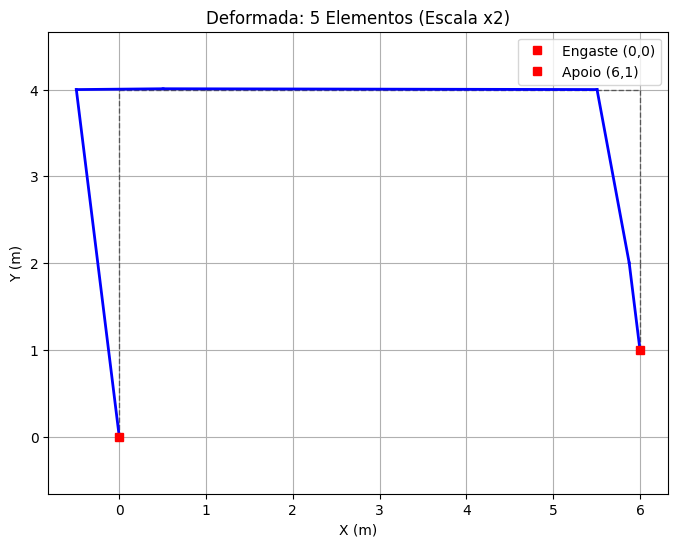

-> Malha Grossa: 5 Elementos. Deslocamento Máx: 2.474017e-01 m


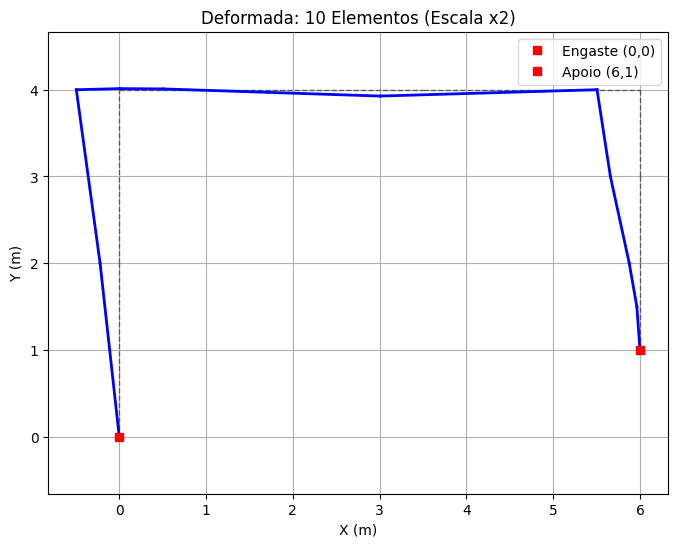

-> Malha Média: 10 Elementos. Deslocamento Máx: 2.500762e-01 m


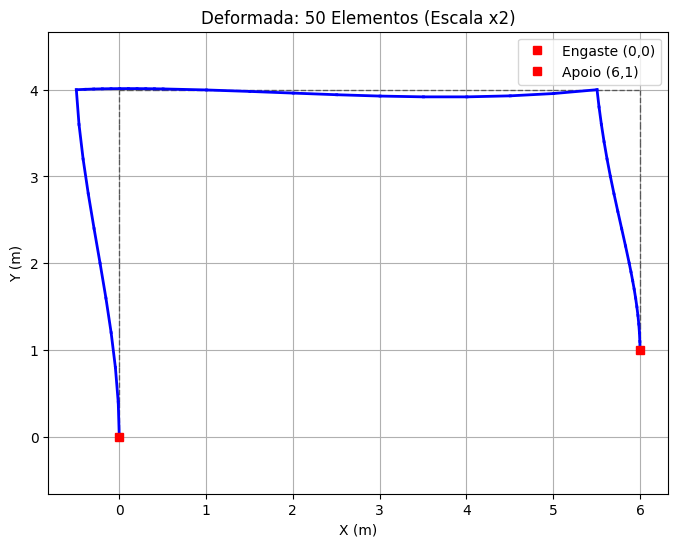

-> Malha Fina: 50 Elementos. Deslocamento Máx: 2.507992e-01 m
Diferença percentual entre 5 e 50 elementos: 1.3547%


In [31]:
# Caso 1: Malha Mínima (5 elementos)
n_el_1, max_d_1, u_1 = resolver_portico(divisoes_por_segmento=1, plotar=True)
print(f"-> Malha Grossa: {n_el_1} Elementos. Deslocamento Máx: {max_d_1:.6e} m")

# Caso 2: Malha Média (10 elementos)
n_el_2, max_d_2, u_2 = resolver_portico(divisoes_por_segmento=2, plotar=True)
print(f"-> Malha Média: {n_el_2} Elementos. Deslocamento Máx: {max_d_2:.6e} m")

# Caso 3: Malha Fina (50 elementos)
n_el_3, max_d_3, u_3 = resolver_portico(divisoes_por_segmento=10, plotar=True)
print(f"-> Malha Fina: {n_el_3} Elementos. Deslocamento Máx: {max_d_3:.6e} m")

# Comparação Final
diff = abs(max_d_3 - max_d_1)
perc = (diff / max_d_3) * 100
print(f"Diferença percentual entre 5 e 50 elementos: {perc:.4f}%")